# Payoff d'un strangle long sur SPY

Ce TP documente le payoff d'un strangle européen (put OTM + call OTM) sur SPY.
Objectifs pédagogiques :
1. Examiner l'historique de SPY sur un an pour fixer un spot de référence.
2. Définir les strikes d'un strangle (put plus bas, call plus haut) autour du spot.
3. Tracer payoff et P&L (prime BS), afficher points morts et payoff interactif.


In [1]:

import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import sys
from pathlib import Path
from IPython.display import display, Markdown

_base = Path.cwd().resolve()
for extra in (_base, _base.parent, _base.parent.parent):
    candidate = extra / "notebooks" / "scripts"
    if candidate.exists() and str(candidate) not in sys.path:
        sys.path.insert(0, str(candidate))
        break
from pricing import fetch_spy_history, view_strangle, payoff_strangle
plt.style.use("seaborn-v0_8-darkgrid")

close_spy = fetch_spy_history()
spot_ref = float(close_spy.iloc[-1])

k_put = spot_ref * 0.95
k_call = spot_ref * 1.05
view_static = view_strangle(spot_ref, k_put, k_call)
premium = view_static["premium"]
be_low, be_high = view_static["breakevens"]


D:\PythonDProjects\PaperTradingApp\notebooks\scripts\pricing.py:47: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("SPY", period=period, interval=interval, progress=False)
C:\Users\nicol\AppData\Local\Temp\ipykernel_31196\1693699865.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spot_ref = float(close_spy.iloc[-1])


## Évolution du sous-jacent (SPY)
Historique des clôtures sur un an et repère du spot de référence (dernier close).


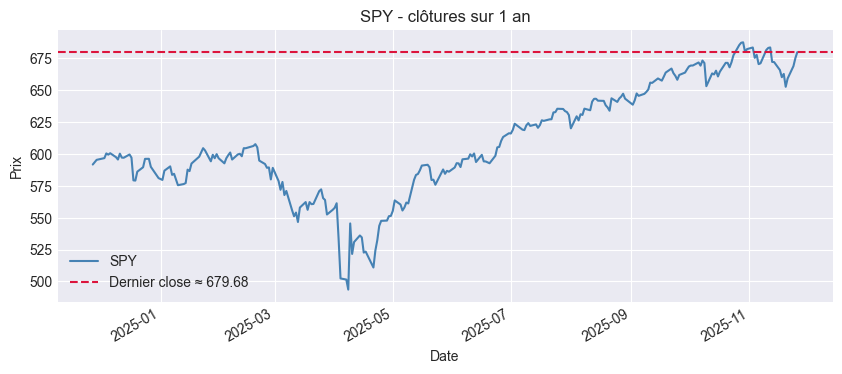

In [2]:

fig, ax = plt.subplots(figsize=(10, 4))
close_spy.plot(ax=ax, color="steelblue", label="SPY close")
ax.axhline(spot_ref, color="crimson", linestyle="--", label=f"Dernier close ≈ {spot_ref:.2f}")
ax.set_title("SPY - clôtures sur 1 an")
ax.set_xlabel("Date")
ax.set_ylabel("Prix")
ax.legend()
plt.show()


## Payoff du strangle long
Payoff = put OTM + call OTM. On affiche payoff brut, P&L net (payoff - prime) et points morts issus de la prime BS.


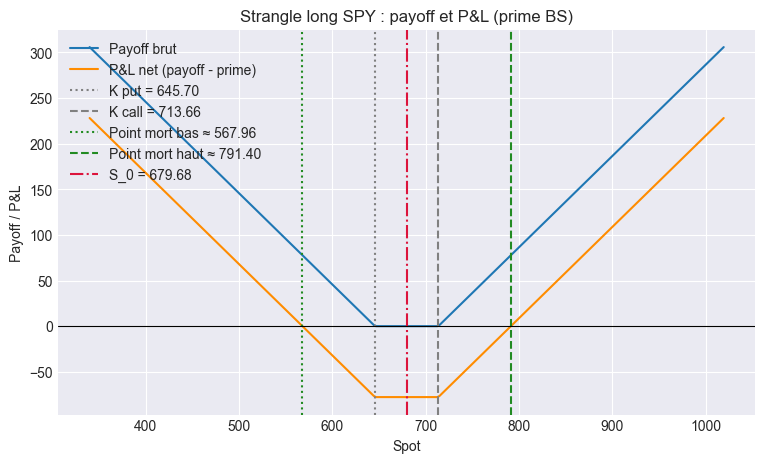

**Prime (BS) ≈ 77.7378**

- Points morts : 567.96 / 791.40
- Prime calculée avec les paramètres par défaut du module de pricing.

In [3]:

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(view_static["s_grid"], view_static["payoff"], label="Payoff brut")
ax.plot(view_static["s_grid"], view_static["pnl"], label="P&L net (payoff - prime)", color="darkorange")
ax.axvline(k_put, color="gray", linestyle=":", label=f"K put = {k_put:.2f}")
ax.axvline(k_call, color="gray", linestyle="--", label=f"K call = {k_call:.2f}")
ax.axvline(be_low, color="forestgreen", linestyle=":", label=f"Point mort bas ≈ {be_low:.2f}")
ax.axvline(be_high, color="forestgreen", linestyle="--", label=f"Point mort haut ≈ {be_high:.2f}")
ax.axvline(spot_ref, color="crimson", linestyle="-.", label=f"S_0 = {spot_ref:.2f}")
ax.axhline(0, color="black", linewidth=0.8)
ax.set_xlabel("Spot")
ax.set_ylabel("Payoff / P&L")
ax.set_title("Strangle long SPY : payoff et P&L (prime BS)")
ax.legend(loc="upper left")
plt.show()

display(Markdown(f"""**Prime (BS) ≈ {premium:.4f}**

- Points morts : {be_low:.2f} / {be_high:.2f}
- Prime calculée avec les paramètres par défaut du module de pricing."""))


## Payoff interactif
Curseurs pour explorer payoff, P&L net et points morts en fonction de S_0, S_T, K put et K call (prime recalculée).


In [4]:

spot0_slider = widgets.FloatSlider(value=spot_ref, min=spot_ref*0.5, max=spot_ref*1.5, step=1.0, description='S_0')
spotT_slider = widgets.FloatSlider(value=spot_ref, min=spot_ref*0.5, max=spot_ref*1.5, step=1.0, description='S_T')
slider_put = widgets.FloatSlider(value=k_put, min=spot_ref*0.5, max=spot_ref*1.2, step=1.0, description='K put')
slider_call = widgets.FloatSlider(value=k_call, min=spot_ref*0.8, max=spot_ref*1.5, step=1.0, description='K call')
output = widgets.Output()

def _update_payoff(change=None):
    with output:
        output.clear_output()
        s0 = spot0_slider.value
        sT = spotT_slider.value
        k_put_val = slider_put.value
        k_call_val = slider_call.value

        view_dyn = view_strangle(s0, k_put_val, k_call_val)
        premium_dyn = view_dyn["premium"]
        be_low, be_high = view_dyn["breakevens"]
        payoff_T = float(payoff_strangle(sT, k_put_val, k_call_val))
        pnl_T = payoff_T - premium_dyn

        fig, ax = plt.subplots(figsize=(7, 4))
        ax.plot(view_dyn["s_grid"], view_dyn["payoff"], label='Payoff brut')
        ax.plot(view_dyn["s_grid"], view_dyn["pnl"], label='P&L net', color='darkorange')
        ax.axvline(k_put_val, color='gray', linestyle=':', label=f'K put = {k_put_val:.2f}')
        ax.axvline(k_call_val, color='gray', linestyle='--', label=f'K call = {k_call_val:.2f}')
        ax.axvline(be_low, color='forestgreen', linestyle=':', label=f'Point mort bas ≈ {be_low:.2f}')
        ax.axvline(be_high, color='forestgreen', linestyle='--', label=f'Point mort haut ≈ {be_high:.2f}')
        ax.axvline(s0, color='crimson', linestyle='-.', label=f'S_0 = {s0:.2f}')
        ax.axhline(0, color='black', linewidth=0.8)
        ax.scatter([sT], [pnl_T], color='gold', zorder=5, label=f'P&L à S_T = {pnl_T:.2f}')
        ax.set_xlabel('Spot')
        ax.set_ylabel('Payoff / P&L')
        ax.legend(loc='lower right')
        ax.set_title('Payoff et P&L du strangle')
        plt.show()

        display(Markdown(f"""**S_0 = {s0:.2f}**, **S_T = {sT:.2f}**

- K put = {k_put_val:.2f}
- K call = {k_call_val:.2f}
- Prix (BS) = {premium_dyn:.4f}
- Payoff à l'expiration = {payoff_T:.4f}
- P&L net = {pnl_T:.4f}
- Points morts ≈ {be_low:.2f} / {be_high:.2f}"""))

for sl in (spot0_slider, spotT_slider, slider_put, slider_call):
    sl.observe(_update_payoff, names='value')

_update_payoff()
display(widgets.VBox([spot0_slider, spotT_slider, slider_put, slider_call, output]))
